###  MicroGrad demo

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

In [3]:
np.random.seed(1337)
random.seed(1337)

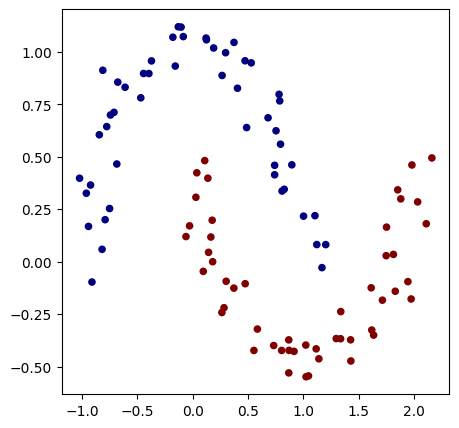

In [4]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [5]:
# initialize a model 
model = MLP(2, [8, 8, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer 'l0' of [ReluBlendedNeuron(2), ReluBlendedNeuron(2), ReluBlendedNeuron(2)], Layer 'l1' of [ReluBlendedNeuron(3), ReluBlendedNeuron(3), ReluBlendedNeuron(3)], Layer 'l2' of [NoopNeuron(3)]]
number of parameters 31


In [6]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

+:(data=3.05411, grad=0.00000) 0.5


In [7]:
# optimization
steps = 1000

def sgn(value:float):
    if value >= 0:
        return 1.   
    return -1.


for p in model.parameters():
    p.last_grad = 0

last_local_learning_rate = 1

class PController:
    def __init__(self, setpoint, kp):
        print(f"PController setpoint is {setpoint}")
        self.setpoint = setpoint  # Desired setpoint
        self.kp = kp              # Proportional gain

    def compute(self, feedback):
        error = self.setpoint - feedback
        control_signal = self.kp * error
        return control_signal
    
num_features = len(model.parameters())
    
params = np.random.randn(num_features)
gradients = np.random.randn(num_features)
m = np.zeros(num_features)
v = np.zeros(num_features)
    
def adam_optimizer(params, gradients, m, v, t, learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
    m = beta1 * m + (1 - beta1) * gradients
    v = beta2 * v + (1 - beta2) * (gradients ** 2)
    m_hat = m / (1 - beta1 ** t)
    v_hat = v / (1 - beta2 ** t)
    
    params -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
    
    return params, m, v
    
pcontroller = PController(len(model.parameters()) * 0.1,.001)


for k in range(steps):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/steps
    max_grad = 0
    num_sgn_switches = 0
    ps = model.parameters()
    for i in range(len(ps)):
        params[i] = ps[i].data
        gradients[i] = ps[i].grad

    params, m, v = adam_optimizer(params, gradients, m, v, k+1)

    for i in range(len(ps)):
        ps[i].data = params[i]
        ps[i].grad = gradients[i]

    for p in model.parameters():
        max_grad = max(max_grad,abs(p.grad))
        sgn_switch = sgn(p.grad) != sgn(p.last_grad)
        num_sgn_switches += sgn_switch
        p.last_grad = p.grad

    if acc >= 1.:
        break
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc:.2%}%, max grad {max_grad}, sgn switches {num_sgn_switches}")


PController setpoint is 3.1
step 0 loss 3.054114365866612, accuracy 50.00%%, max grad 2.0219493239443924, sgn switches 12
step 1 loss 2.9126886257330598, accuracy 50.00%%, max grad 1.9773686295565949, sgn switches 0
step 2 loss 2.772271760265565, accuracy 50.00%%, max grad 1.9325777830325033, sgn switches 0
step 3 loss 2.632905686430373, accuracy 50.00%%, max grad 1.8876046994327813, sgn switches 0
step 4 loss 2.4946232553136225, accuracy 50.00%%, max grad 1.8424779191429732, sgn switches 0
step 5 loss 2.3574479565971513, accuracy 50.00%%, max grad 1.7972263168299891, sgn switches 0
step 6 loss 2.2213941085141373, accuracy 50.00%%, max grad 1.751878954045725, sgn switches 1
step 7 loss 2.0864674043994786, accuracy 50.00%%, max grad 1.7064651323803035, sgn switches 0
step 8 loss 1.953356188358127, accuracy 50.00%%, max grad 1.5587717168677464, sgn switches 1
step 9 loss 1.8505258674866996, accuracy 50.00%%, max grad 1.0481273139798741, sgn switches 0
step 10 loss 1.7788134344061919, acc

In [8]:
print(model.layers[1].neurons[0])

ReluBlendedNeuron(3)


(-1.1486392982686429, 1.80136070173136)

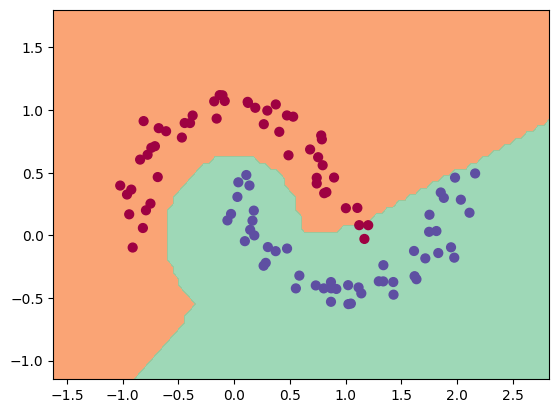

In [9]:
# visualize decision boundary

model.layers[0].neurons[0].active = True
model.layers[0].neurons[1].active = True
model.layers[0].neurons[2].active = True
model.layers[1].neurons[0].active = True

h = 0.05
x_min, x_max = X[:, 0].min() - 0.6, X[:, 0].max() + 0.7
y_min, y_max = X[:, 1].min() - 0.6, X[:, 1].max() + 0.7
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())


In [10]:
model.layers[2].neurons[0].w


[.l2n0.w0:(data=0.59934, grad=0.00012),
 .l2n0.w1:(data=0.72644, grad=-0.01009),
 .l2n0.w2:(data=-1.87597, grad=0.00310)]